# PM2.5 prediction

### Import libraries

In [1]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
from scipy.stats import stats
seed(1)
from fs import methods as m
from fs import model as ml
import geopandas as gpd
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score


### Data Import

2022-05-17 10:34:45.182258: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 10:34:45.183189: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Mean Absolute Error:  7.687962615122649
Mean Squared Error:  75.64597976274803
R2 score:  -2.96928804522438
---------grid_0_01_0418_0425_2021.gpkg---------
Train on 18 samples, validate on 7 samples
Epoch 1/50
18/18 [==============================] - 1s 47ms/sample - loss: 0.2476 - mse: 0.2476 - mae: 0.4194 - val_loss: 0.1851 - val_mse: 0.1851 - val_mae: 0.3687

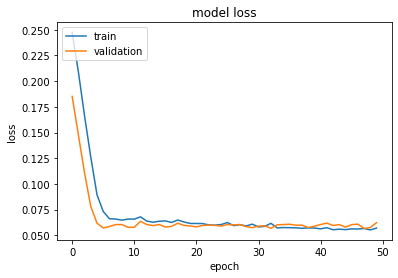

---------VALIDATION WITH ARPA---------
Values predicted:  [[18.991203]
 [19.977613]
 [19.621965]
 [20.076092]
 [17.702654]
 [16.488073]
 [19.11427 ]
 [19.97483 ]
 [19.933115]]
Values :  [[14.875     ]
 [18.42857143]
 [19.        ]
 [20.5       ]
 [15.625     ]
 [19.75      ]
 [20.125     ]
 [23.875     ]
 [21.375     ]]
Mean Absolute Error:  2.0448316241067555
Mean Squared Error:  5.9086601404791566
Mean (Y-test): 19.28373015873016
Mean (Y-predicted):  19.09776
R2 score:  0.13521439998665952
---------VALIDATION WITH CAMS---------
Mean Absolute Error:  6.927279612597297
Mean Squared Error:  55.69074678894335
Mean (Y-test): 25.6014147085302
Mean (Y-predicted):  19.039392415214987
R2 score:  -1.9221991195337593
Mean Absolute Error:  3.7179345358537863
Mean Squared Error:  19.282325433051444
R2 score:  -2.2310027726080595
---------grid_0_01_0903_0910_2021.gpkg---------
Train on 19 samples, validate on 7 samples
Epoch 1/50
19/19 [==============================] - 0s 5ms/sample - loss: 0.037

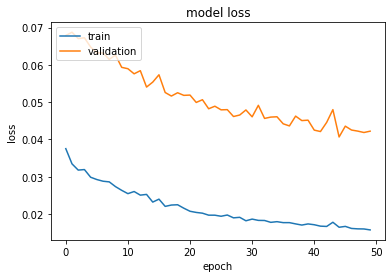

---------VALIDATION WITH ARPA---------
Values predicted:  [[14.411593]
 [ 9.455273]
 [12.273018]
 [11.47735 ]
 [11.018405]
 [14.420814]
 [11.903292]
 [11.709276]
 [ 9.811464]]
Values :  [[17.75      ]
 [14.125     ]
 [ 8.4125    ]
 [12.85714286]
 [18.        ]
 [13.375     ]
 [ 8.625     ]
 [12.625     ]
 [13.75      ]]
Mean Absolute Error:  3.2676004651993042
Mean Squared Error:  14.076993658344186
Mean (Y-test): 13.279960317460317
Mean (Y-predicted):  11.831165
R2 score:  -0.4207598682717655
---------VALIDATION WITH CAMS---------
Mean Absolute Error:  5.247626767839704
Mean Squared Error:  29.680622914834125
Mean (Y-test): 17.43536695752825
Mean (Y-predicted):  12.187740189688546
R2 score:  -3.9733718717445896
Mean Absolute Error:  2.2580210705765156
Mean Squared Error:  7.799952757317353
R2 score:  -1.9186262944031327
---------grid_0_01_0717_0724_2021.gpkg---------
Train on 18 samples, validate on 7 samples
Epoch 1/50
18/18 [==============================] - 0s 5ms/sample - loss: 0.

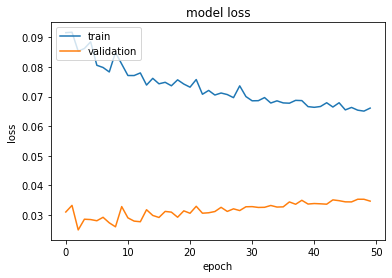

---------VALIDATION WITH ARPA---------
Values predicted:  [[13.364096]
 [12.782967]
 [13.2635  ]
 [13.748431]
 [13.487046]
 [13.903587]
 [12.1132  ]
 [12.00004 ]
 [13.974019]]
Values :  [[10.77142857]
 [10.75      ]
 [ 9.5       ]
 [12.75      ]
 [17.        ]
 [14.875     ]
 [14.75      ]
 [12.        ]
 [13.875     ]]
Mean Absolute Error:  1.8453100537496898
Mean Squared Error:  5.140297716125616
Mean (Y-test): 12.91904761904762
Mean (Y-predicted):  13.181877
R2 score:  0.007798636548896787
---------VALIDATION WITH CAMS---------
Mean Absolute Error:  1.3074112078722786
Mean Squared Error:  2.7468944860305156
Mean (Y-test): 12.17746475163628
Mean (Y-predicted):  13.341942899367389
R2 score:  -0.027847055529730103
Mean Absolute Error:  9.06358289531633
Mean Squared Error:  111.80843526265691
R2 score:  -0.7623323386068748
---------grid_0_01_0324_0331_2021.gpkg---------
Train on 18 samples, validate on 7 samples
Epoch 1/50
18/18 [==============================] - 0s 5ms/sample - loss: 0

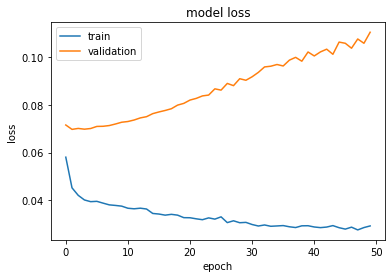

---------VALIDATION WITH ARPA---------
Values predicted:  [[34.979443]
 [29.345215]
 [24.518637]
 [28.60074 ]
 [25.557144]
 [25.075777]
 [34.438046]
 [27.037823]
 [29.30025 ]]
Values :  [[27.25 ]
 [35.   ]
 [26.5  ]
 [31.25 ]
 [37.375]
 [24.75 ]
 [41.125]
 [26.125]
 [20.   ]]
Mean Absolute Error:  5.228723314073351
Mean Squared Error:  41.608482345637945
Mean (Y-test): 29.930555555555557
Mean (Y-predicted):  28.761454
R2 score:  -0.020188111809048337
---------VALIDATION WITH CAMS---------
Mean Absolute Error:  11.01576676088221
Mean Squared Error:  141.17055645653613
Mean (Y-test): 38.61625738704906
Mean (Y-predicted):  28.939566500046674
R2 score:  -1.2251401365025165
Mean Absolute Error:  4.584263757943603
Mean Squared Error:  30.29232353439012
R2 score:  -0.3096964658843866
---------grid_0_01_1007_1017_2021.gpkg---------
Train on 19 samples, validate on 7 samples
Epoch 1/50
19/19 [==============================] - 0s 5ms/sample - loss: 0.0738 - mse: 0.0738 - mae: 0.2320 - val_loss: 

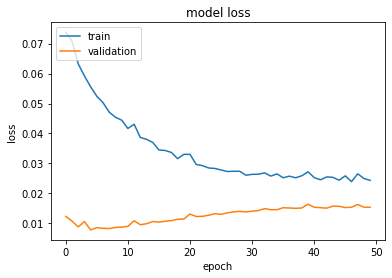

---------VALIDATION WITH ARPA---------
Values predicted:  [[18.478996]
 [19.626904]
 [12.673191]
 [18.043905]
 [14.400194]
 [16.678968]
 [12.9443  ]
 [14.33687 ]
 [13.426327]]
Values :  [[15.        ]
 [22.45454545]
 [15.66666667]
 [22.81818182]
 [19.81818182]
 [13.7       ]
 [11.40909091]
 [16.27272727]
 [14.33333333]]
Mean Absolute Error:  2.983268764765575
Mean Squared Error:  10.77883326865457
Mean (Y-test): 16.83030303030303
Mean (Y-predicted):  15.623296
R2 score:  0.23525664444886263
---------VALIDATION WITH CAMS---------
Mean Absolute Error:  5.520491981506348
Mean Squared Error:  37.62894994081765
Mean (Y-test): 21.208580344063893
Mean (Y-predicted):  16.27670786721366
R2 score:  -0.6268974116983852


In [2]:
RESOLUTION = '0_01'
geopackages = os.listdir('grids_'+RESOLUTION)
#geopackages.remove('.DS_Store')

TARGET = 'pm25_st'
NUMBER_OF_PARAMS = 8
NUMBER_OF_COVARIATES = NUMBER_OF_PARAMS + 2

model = Sequential()
model.add(Dense(NUMBER_OF_COVARIATES, input_dim=NUMBER_OF_COVARIATES, kernel_initializer='normal', activation='relu'))
model.add(Dense(NUMBER_OF_COVARIATES/2, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])



for grid in geopackages:
    data = gpd.read_file('grids_'+RESOLUTION+'/'+ grid)

    coll = pd.DataFrame()
    coll['pm25_st'] = data['pm25_st']
    coll['pm25_cams'] = data['pm25_cams']
    coll = coll.dropna(axis=0)

    print('Mean Absolute Error: ',mean_absolute_error(coll['pm25_cams'], coll['pm25_st'], ))
    print('Mean Squared Error: ',mean_squared_error(coll['pm25_cams'], coll['pm25_st']))
    print('R2 score: ',r2_score(coll['pm25_cams'], coll['pm25_st']))


    data = data[~data[TARGET].isnull()]
    data = data.dropna(axis=1)


    data.pop('geometry')
    data.pop('bottom')
    data.pop('top')
    data.pop('left')
    data.pop('right')


    #labels = pd.read_csv('features_' +RESOLUTION +'/'+grid[:-5]+'.csv')['Features']
    labels = pd.read_csv('fs.csv')['Features']

    labels = ml.remove_int_values(labels.tolist())
    #data.pop('pm25_cams')
    #labels.remove('pm25_cams')


    #read variables which are not null
    score_results = pd.DataFrame()

    #Store dataset in x and y variables
    X = pd.DataFrame(data=data, columns=labels ).dropna(axis = 1)
    X = X.iloc[:, :NUMBER_OF_PARAMS]
    X['lat_cen'] = data['lat_cen']
    X['lng_cen'] = data['lng_cen']

    Y = pd.DataFrame(data=data, columns=[TARGET] )
    Y = Y.values.ravel()


    #NUMBER_OF_COVARIATES = X.shape[1]
    y1 = np.array(Y)

    X_train, X_val, y_train, y_val = train_test_split(X, y1, test_size=0.25)

    y_train=np.reshape(y_train, (-1,1))
    y_val=np.reshape(y_val, (-1,1))

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaler_x.fit(X_train)
    xtrain_scale=scaler_x.transform(X_train)
    scaler_x.fit(X_val)
    xval_scale=scaler_x.transform(X_val)

    scaler_y.fit(y_train)
    ytrain_scale=scaler_y.transform(y_train)
    scaler_y.fit(y_val)
    yval_scale=scaler_y.transform(y_val)
    print('---------'+ grid +'---------')


    history=model.fit(xtrain_scale, ytrain_scale, epochs=50, batch_size=1, verbose=1, validation_split=0.25)
    predictions = model.predict(xval_scale)

    print(history.history.keys())
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.plot(history.history['accuracy'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    predictions = scaler_y.inverse_transform(predictions)

    print('---------VALIDATION WITH ARPA---------')
    print('Values predicted: ', predictions)
    print('Values : ', scaler_y.inverse_transform(yval_scale))

    print('Mean Absolute Error: ',mean_absolute_error(y_val, predictions))
    print('Mean Squared Error: ',mean_squared_error(y_val, predictions))
    print('Mean (Y-test):',np.mean(y_val))
    print('Mean (Y-predicted): ',np.mean(predictions))
    print('R2 score: ',r2_score(y_val, predictions))

    #%%

    data_new = gpd.read_file('grids_'+RESOLUTION+'/'+ grid)
    data_new = data_new[~data_new[TARGET].isnull()]
    pm25_obs = data_new['pm25_cams']
    X_new = pd.DataFrame(data=data_new, columns=labels).dropna(axis=1)
    X_new = X_new.iloc[:, :NUMBER_OF_PARAMS]

    X_new['lat_cen'] = data_new['lat_cen']
    X_new['lng_cen'] = data_new['lng_cen']
    scaler_x = MinMaxScaler()
    scaler_x.fit(X_new)
    X_new_scale=scaler_x.transform(X_new)




    predictions_pm25 = model.predict(X_new_scale,  batch_size=1)
    predictions_pm25 = pd.Series(np.array(scaler_y.inverse_transform(predictions_pm25)).reshape((-1,)))
    e = pd.DataFrame()

    e['predictions_pm25'] = list(predictions_pm25)
    e['pm25_obs'] = list(pm25_obs)
    e = e.dropna(axis=0)
    print('---------VALIDATION WITH CAMS---------')
    print('Mean Absolute Error: ',mean_absolute_error(e['pm25_obs'], e['predictions_pm25']))
    print('Mean Squared Error: ',mean_squared_error(e['pm25_obs'], e['predictions_pm25']))
    print('Mean (Y-test):',np.mean(e['pm25_obs']))
    print('Mean (Y-predicted): ',np.mean(e['predictions_pm25']))
    print('R2 score: ',r2_score(e['pm25_obs'], e['predictions_pm25']))